# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import sys
sys.path.append("..")


In [3]:
from util import show, plot_images, plot_tensors

c:\Users\ADMIN\anaconda3\envs\0726_noise2self\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr


from skimage.io import imread, imshow_collection
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
plt.rc('figure', figsize = (5,5))

(800, 800)


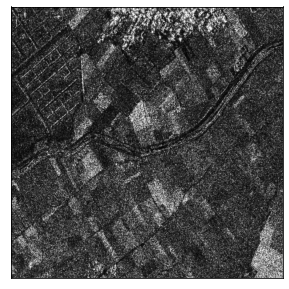

In [109]:
import cv2
from PIL import Image
import os 
#path = "D:/noise2self-master/noise2self-master/sar_data"
# 이미지 읽기
img_gray = cv2.imread(
    os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 
    'noisy_sample.png')
    )
# img_gray = cv2.imread(
#     os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data',
#     'capt19.png')
#     )

# 컬러 이미지를 그레이스케일로 변환
img_cv_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
img_cv_gray = cv2.resize(img_cv_gray, (800, 800))
show(img_cv_gray)
print(img_cv_gray.shape)

# 이미지 저장
#cv2.imwrite(path, img_cv_gray)
#cv2.imwrite("D:/noise2self-master/noise2self-master/ddiirr", img_cv_gray)
# 이미지 사이즈 변경
# img_gray_resize = cv2.resize(img_cv_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)  # 가로, 세로 모두 반으로 줄이기
# img_gray_reduced = cv2.resize(img_cv_gray, None, interpolation=cv2.INTER_AREA)



# 이미지 화면으로 보기
# cv2.imshow('color', img_gray)  # color라는 이름의 윈도우 안에 img_gray 이미지 보여주기
# cv2.imshow('gray-scale', img_gray_resize)
# cv2.imshow('gray-scale reduced', img_gray_reduced)



In [110]:
img_cv_gray

array([[  6,   9,  31, ...,  15,  41,  22],
       [ 36,  31,  40, ...,  83,  24,  41],
       [ 11,  37,  20, ...,  68,  70,  40],
       ...,
       [ 81,  34,  28, ..., 164, 150, 255],
       [ 54,  49,  61, ..., 139, 157, 224],
       [ 25,  81, 118, ..., 217,  64,   7]], dtype=uint8)

In [111]:
img_cv_gray = img_cv_gray * 2 

In [112]:
img_cv_gray

array([[ 12,  18,  62, ...,  30,  82,  44],
       [ 72,  62,  80, ..., 166,  48,  82],
       [ 22,  74,  40, ..., 136, 140,  80],
       ...,
       [162,  68,  56, ...,  72,  44, 254],
       [108,  98, 122, ...,  22,  58, 192],
       [ 50, 162, 236, ..., 178, 128,  14]], dtype=uint8)

In [113]:
np.max(img_cv_gray)

254

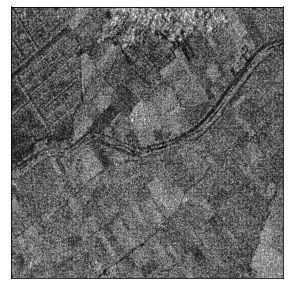

In [114]:
show(img_cv_gray)

In [117]:
import torch 
temp2 = torch.FloatTensor(np.array([255] * 800 * 800))
temp2 = temp2.view([800, 800])
print(temp2)

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


tensor([[-243., -237., -193.,  ..., -225., -173., -211.],
        [-183., -193., -175.,  ...,  -89., -207., -173.],
        [-233., -181., -215.,  ..., -119., -115., -175.],
        ...,
        [ -93., -187., -199.,  ..., -183., -211.,   -1.],
        [-147., -157., -133.,  ..., -233., -197.,  -63.],
        [-205.,  -93.,  -19.,  ...,  -77., -127., -241.]])


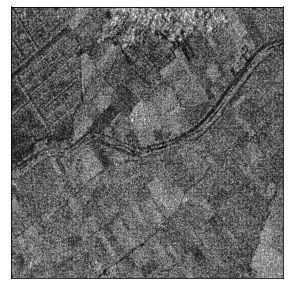

In [121]:
rs = torch.FloatTensor(img_cv_gray) - temp2
print(rs)
show(rs)

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


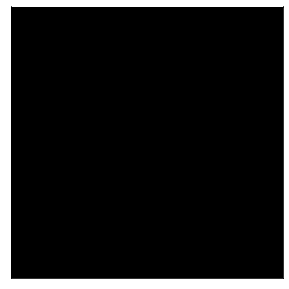

In [128]:
temp3 = torch.FloatTensor(np.array([255]*800*800))
temp3 = temp3.view([800, 800])
print(temp3)
show(temp3)

In [78]:
img_cv_gray[0]

array([  6,   9,  31,  29,  15,  22,  32,  67,  95,  16,  46,  92,  29,
        17,  89,  81, 184, 189, 141, 191, 255, 255, 230,  44, 175, 245,
       154, 216, 121,  50,  39,  19,  43,  52,   5,   7,  23,   8,   4,
         7,  17,  73,  76,  91, 163,  32,  55,  15,   7,  44,  15,  15,
        88,  94,  38,  31,  57,  40,  64,  64,   5,  10,  16,   7,  16,
        52,  55,  40,  50,  15,  34,  13,  33, 121,  42,  66,  68,  38,
        15,  23,  51,  23,  63,   2,  97,  27,  23,  20,  39,  59,  36,
        14,  63, 142, 189,  97, 242,  60,  60,  38,  26,  29,  28,  30,
        37,  44,  39, 124,  87,  17,  20,  13,  10,  17,  57,  84,  56,
       110,  92,  38, 121,  82, 123,  60,  91, 102,  54,  38,   9,   4,
         1,   9,  21,   9,  19,  39,  88,  79,  28,  15,  13,  23,  14,
        59,  70,  78, 163, 165, 157, 189, 133,  17,  41,  27,  16, 249,
        48,  23, 124,  74,  16,  19, 118, 255, 255, 221,  10,  21,  12,
         5, 185, 114,  42,  97, 151, 125,  91, 164, 109,  33,   

In [79]:
import torch
fFlag255 = torch.Tensor(np.array([255]*800*800))
fFlag255 = fFlag255.view(img_cv_gray.shape)

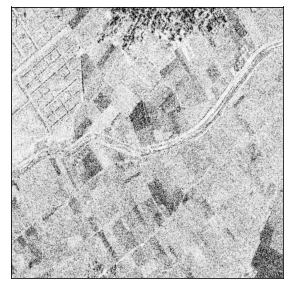

In [80]:
show(fFlag255 - img_cv_gray)

In [81]:
temp_dark = fFlag255 - img_cv_gray 
print(temp_dark)

tensor([[249., 246., 224.,  ..., 240., 214., 233.],
        [219., 224., 215.,  ..., 172., 231., 214.],
        [244., 218., 235.,  ..., 187., 185., 215.],
        ...,
        [174., 221., 227.,  ...,  91., 105.,   0.],
        [201., 206., 194.,  ..., 116.,  98.,  31.],
        [230., 174., 137.,  ...,  38., 191., 248.]])


In [82]:
torch.max(temp_dark)

tensor(255.)

# AHGN (Additive Half Gaussian Noise)

In [83]:
data = [127.5] * 800 * 800
half_data = torch.Tensor(np.array(data))
half_data = half_data.view([800, 800])
print(half_data)

tensor([[127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000],
        [127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000],
        [127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000],
        ...,
        [127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000],
        [127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000],
        [127.5000, 127.5000, 127.5000,  ..., 127.5000, 127.5000, 127.5000]])


# ADGN (Additive Dark Gaussian Noise)

In [27]:
from random import randint
data = [randint(0, 255) for _ in range(800*800)]
# data = [randint(0, 255)*2 for _ in range(800*800)]
random_data = torch.Tensor(np.array(data))
print(random_data)


tensor([179., 253.,  93.,  ..., 207.,  55., 183.])


In [28]:
random_data = random_data.view([800, 800])
# random_data = torch.randn(800, 800)

In [29]:
random_data

tensor([[179., 253.,  93.,  ...,  23.,  70., 171.],
        [ 16.,  26.,  41.,  ..., 243., 241.,  92.],
        [139., 145.,  60.,  ..., 175.,  31., 152.],
        ...,
        [104.,  36.,  19.,  ...,  28., 198.,  11.],
        [ 46.,  99., 149.,  ...,  67., 122.,  82.],
        [ 29., 245., 185.,  ..., 207.,  55., 183.]])

In [30]:
random_data = np.array(random_data)
random_data = np.where(random_data < 0, 0, random_data)
random_data = np.where(random_data > 255, 255, random_data)
random_data = torch.Tensor(random_data)
print(random_data)

tensor([[179., 253.,  93.,  ...,  23.,  70., 171.],
        [ 16.,  26.,  41.,  ..., 243., 241.,  92.],
        [139., 145.,  60.,  ..., 175.,  31., 152.],
        ...,
        [104.,  36.,  19.,  ...,  28., 198.,  11.],
        [ 46.,  99., 149.,  ...,  67., 122.,  82.],
        [ 29., 245., 185.,  ..., 207.,  55., 183.]])


# MINUS Gaussian Noise 

In [84]:
# minus_gaussian = temp_dark - random_data  ... ADGN
minus_gaussian = temp_dark - half_data      # ... AHGN
print(minus_gaussian)

tensor([[ 121.5000,  118.5000,   96.5000,  ...,  112.5000,   86.5000,
          105.5000],
        [  91.5000,   96.5000,   87.5000,  ...,   44.5000,  103.5000,
           86.5000],
        [ 116.5000,   90.5000,  107.5000,  ...,   59.5000,   57.5000,
           87.5000],
        ...,
        [  46.5000,   93.5000,   99.5000,  ...,  -36.5000,  -22.5000,
         -127.5000],
        [  73.5000,   78.5000,   66.5000,  ...,  -11.5000,  -29.5000,
          -96.5000],
        [ 102.5000,   46.5000,    9.5000,  ...,  -89.5000,   63.5000,
          120.5000]])


In [85]:
minus_gaussian = np.array(minus_gaussian)
minus_gaussian = np.where(minus_gaussian < 0, 0, minus_gaussian)
minus_gaussian = torch.Tensor(minus_gaussian)
print(minus_gaussian)

tensor([[121.5000, 118.5000,  96.5000,  ..., 112.5000,  86.5000, 105.5000],
        [ 91.5000,  96.5000,  87.5000,  ...,  44.5000, 103.5000,  86.5000],
        [116.5000,  90.5000, 107.5000,  ...,  59.5000,  57.5000,  87.5000],
        ...,
        [ 46.5000,  93.5000,  99.5000,  ...,   0.0000,   0.0000,   0.0000],
        [ 73.5000,  78.5000,  66.5000,  ...,   0.0000,   0.0000,   0.0000],
        [102.5000,  46.5000,   9.5000,  ...,   0.0000,  63.5000, 120.5000]])


In [86]:
torch.max(minus_gaussian)

tensor(127.5000)

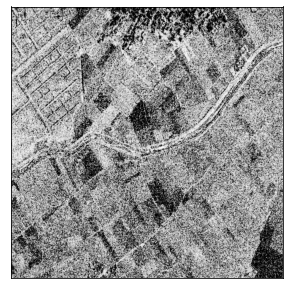

In [87]:
show(minus_gaussian)

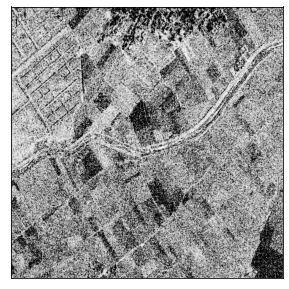

In [95]:
rounded_mgaussian = np.round(minus_gaussian, 0)
show(np.round(minus_gaussian, 0))

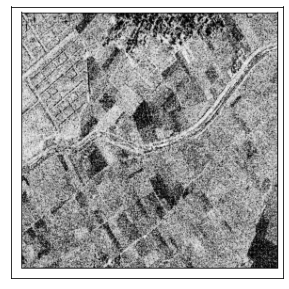

In [90]:
cmp_target = cv2.imread(
    os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 'ahgn.png')
    )
# cmp_target = cv2.resize(cmp_target, (800, 800))
show(cmp_target)

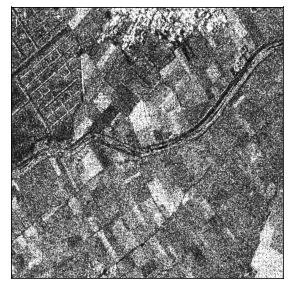

In [43]:
# Test
temp2 = torch.Tensor(np.array([255]*800*800))
temp2 = temp2.view([800, 800])
show(temp2-minus_gaussian)

# Detecting

In [93]:
# =============================================
#   이미지 읽기, 그레이스케일 변환, 사이즈 조절 
# =============================================

img_gray = cv2.imread(os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 'capt9.png')) 
img_cv_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
# self.img_resize = resize(self.img_cv_gray, (self.p.resize,self.p.resize))
# self.img_norm = cv2.normalize(self.img_resize, None, 0, 255, cv2.NORM_MINMAX)
# print(f'self.img_norm : {self.img_norm} \n\n')
print(img_cv_gray)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


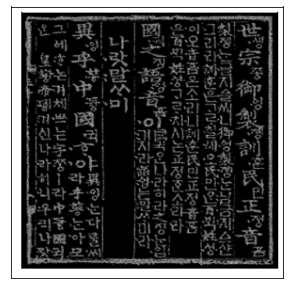

In [95]:
show(torch.Tensor(img_cv_gray))

In [11]:
# dark mode 
img_dark = np.array([1]*640000)

In [12]:
img_dark

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
import torch
fImg_dark = torch.FloatTensor(img_dark)

In [45]:
fImg_dark = fImg_dark.view(img_cv_gray.shape)

In [46]:
fImg_dark

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [47]:
fImg_dark -= img_cv_gray

In [48]:
fImg_dark

tensor([[-254., -254., -254.,  ..., -254., -254., -254.],
        [-254., -254., -254.,  ..., -254., -254., -254.],
        [-254., -254., -254.,  ..., -254., -254., -254.],
        ...,
        [-253., -253., -253.,  ..., -246., -245., -245.],
        [-253., -253., -253.,  ..., -246., -245., -244.],
        [-253., -253., -253.,  ..., -246., -245., -244.]])

In [49]:
img_before = fImg_dark

In [61]:
type(img_before)

torch.Tensor

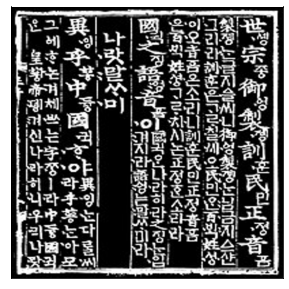

In [50]:
show(img_before)

In [53]:
img_after = np.where(fImg_dark < 0, 0, fImg_dark)

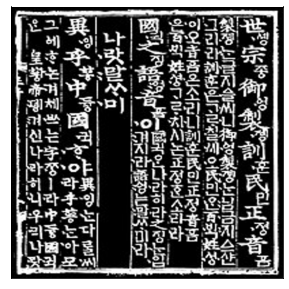

In [36]:
show(img_after)

In [55]:
img_before

tensor([[-254., -254., -254.,  ..., -254., -254., -254.],
        [-254., -254., -254.,  ..., -254., -254., -254.],
        [-254., -254., -254.,  ..., -254., -254., -254.],
        ...,
        [-253., -253., -253.,  ..., -246., -245., -245.],
        [-253., -253., -253.,  ..., -246., -245., -244.],
        [-253., -253., -253.,  ..., -246., -245., -244.]])

(800, 800)


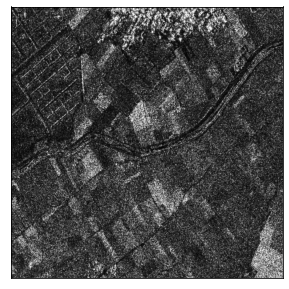

In [7]:

from skimage.transform import resize
img_resize = resize(img_cv_gray, (800,800))
show(img_resize)
print(img_resize.shape)
noisy_image= img_resize

In [8]:
# show(noisy_image)
# print(noisy_image.shape)

In [9]:
# 가우시안 노이즈 입히기 
# np.random.seed(3)
# noisy_image = random_noise(img_resize, mode = 'gaussian', var=5)
# show(noisy_image)
# print(noisy_image.shape)

In [10]:
# gpu 설정하기 
# from util import getbestgpu
# device = getbestgpu()

# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [29]:
r'''
[ masker ]
>>> masker.grid_size = 4
>>> masker.n_masks = 16
>>> makser.mode = 'interpolate'
>>> masker.infer_single_pass = False
>>> masker.include_mask_as_input = False
'''

import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])
# noisy_image = cv2.normalize(img_resize, None, 0, 255, cv2.NORM_MINMAX)
from mask import Masker
masker = Masker(width = 4, mode='zero')

In [30]:
t = np.array([0.5]*640000)

In [14]:
ft = torch.FloatTensor(t)

In [15]:
ft = ft.view(noisy.shape)

In [16]:
test_noisy = noisy - ft

In [17]:
noisy = test_noisy

In [18]:
type(test_noisy)

torch.Tensor

In [19]:
minus_arr = np.array([-1]*640000)

In [20]:
minus_arr = torch.FloatTensor(minus_arr)
minus_arr = minus_arr.view(noisy.shape)

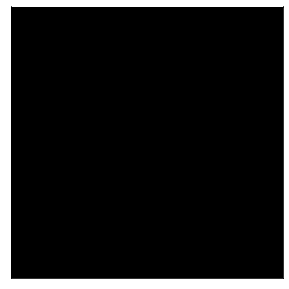

In [26]:
show(minus_arr[0][0])

In [28]:
np.where(minus_arr < 0, 0, minus_arr)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

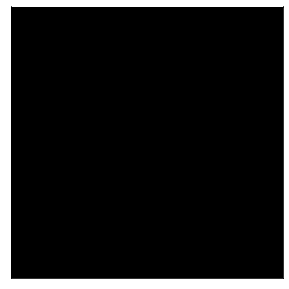

In [29]:
show(minus_arr[0][0])

# Model

For our model, we use a deep convolutional network.

In [31]:
# layers 설정하기
torch.manual_seed(3)
from models.dncnn import DnCNN
model = DnCNN(1, num_of_layers = 7)

In [32]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

186112

In [34]:
noisy_image.ravel().shape


(640000,)

In [35]:
net_input, mask = masker.mask(noisy, 0 % (masker.n_masks - 1))

** shape[-2:] : torch.Size([800, 800])
** A : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
** cnt : 40000


** mask : tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

** mask_inv : tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [36]:
net_input

tensor([[[[0.0000, 0.0414, 0.1217,  ..., 0.0736, 0.1586, 0.0932],
          [0.1393, 0.1238, 0.1587,  ..., 0.3249, 0.0962, 0.1586],
          [0.0500, 0.1440, 0.0788,  ..., 0.2661, 0.2746, 0.1627],
          ...,
          [0.3087, 0.1358, 0.1126,  ..., 0.6423, 0.5888, 0.9803],
          [0.2104, 0.1938, 0.2382,  ..., 0.5456, 0.6154, 0.8653],
          [0.1134, 0.3116, 0.4529,  ..., 0.8360, 0.2711, 0.0779]]]])

In [37]:
net_output = model(net_input)

In [38]:
net_output

tensor([[[[-2.8527e-01,  8.2211e-02, -3.8811e-02,  ...,  1.4107e-01,
           -1.3315e-01,  2.8640e-02],
          [-2.7821e-01,  1.0886e-01,  8.5124e-02,  ..., -2.2373e-01,
           -4.3315e-01,  6.0966e-02],
          [-4.5250e-01, -3.8207e-01, -4.3020e-02,  ..., -2.5703e-01,
           -2.8034e-01,  2.3955e-01],
          ...,
          [ 3.6397e-02,  2.1582e-01,  4.0775e-01,  ...,  8.4647e-02,
           -3.7253e-01,  1.0650e+00],
          [-1.0628e-01, -1.8827e-01, -1.9575e-01,  ..., -7.0656e-01,
           -2.7991e-01, -2.1909e-01],
          [-2.9288e-01, -3.5613e-01, -4.0697e-01,  ..., -3.9351e-01,
           -5.5637e-01, -5.5071e-04]]]], grad_fn=<ConvolutionBackward0>)

# Training

In [16]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
epochs= 1000

In [17]:
# gpu 설정하기
# model = model.to(device)
# noisy = noisy.to(device)

In [50]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(epochs):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = psnr(denoised, noisy_image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.01403 	Val Loss: 	 0.01338
	Model PSNR:  12.12
( 10 ) Loss: 	 0.00164 	Val Loss: 	 0.00239
	Model PSNR:  10.08
( 20 ) Loss: 	 0.00145 	Val Loss: 	 0.00154
	Model PSNR:  10.13
( 30 ) Loss: 	 0.00142 	Val Loss: 	 0.00158
( 40 ) Loss: 	 0.00131 	Val Loss: 	 0.00131
	Model PSNR:  10.22
( 50 ) Loss: 	 0.00128 	Val Loss: 	 0.0013
	Model PSNR:  10.36
( 60 ) Loss: 	 0.00129 	Val Loss: 	 0.00129
	Model PSNR:  10.34
( 70 ) Loss: 	 0.00124 	Val Loss: 	 0.00126
	Model PSNR:  10.36
( 80 ) Loss: 	 0.00121 	Val Loss: 	 0.00124
	Model PSNR:  10.38
( 90 ) Loss: 	 0.00124 	Val Loss: 	 0.00123
	Model PSNR:  10.37


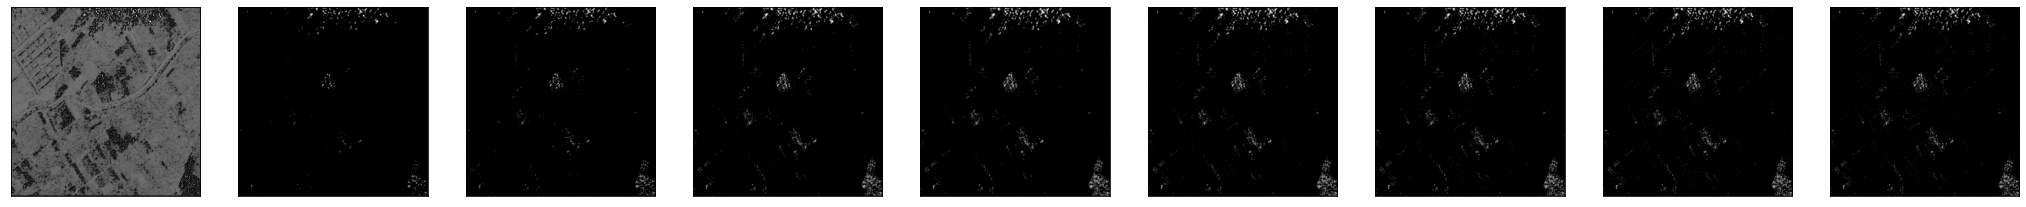

In [51]:
import os 
# path = r"D:\noise2void-master\SAR\result\learingrates=0.01\epochs=5000".replace('\\', '/', 10)
plot_images(best_images[::1])
plt.savefig(os.path.join(r'C:\Users\ADMIN\Desktop\SAR_image\noise2self\noise2self-master\sar_data', 'plot_images2'))


In [ ]:
denoised = best_images[-1]

In [ ]:
inset_x_min = 10
inset_x_max = 170
inset_y_min = 90
inset_y_max = 220

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

In [ ]:
show(get_inset(denoised))
plt.savefig(f'{path}/enlarge')

In [ ]:
inset_x_min = 0
inset_x_max = 800
inset_y_min = 0
inset_y_max = 800

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

In [ ]:
show(get_inset(denoised))
plt.savefig(f'{path}/best')